In [3630]:
import matplotlib
import matplotlib.pyplot as plt
import os
import json
import pickle
import numpy as np
from pathlib import Path
from enum import Enum
import scipy.constants as sc
from scipy.signal import savgol_filter
#from tensorboard.backend.event_processing.event_file_loader import EventFileLoader

#plt = matplotlib.pyplot

In [3631]:
class Tag(Enum):
    CUMULATIVE_REWARD = "cumulative_rewards"
    EP_LENGTH = "ep_length"
    DOOR_PASSAGE = "passage"
    COLLISION_INITIAL = "initial"
    COLLISION_STAY = "stay"
    COLLISION_TOTAL = "total"
    DOOR_GOOD = "good_passage"
    DOOR_BAD = "bad_passage"
    TARGET_REACHED = "target_reached"

class Plot(Enum):
    COLLISION = 0
    ENV1 = 1
    ENV2 = 2
    LINEPLOT = 3
    RESULT_DATA_ENV1 = 4
    RESULT_DATA_ENV2 = 5
    DOOR = 6
    DOOR_HIST = 7
    SENSOR_STUDY_EP_LENGTH = 8
    SENSOR_STUDY_REWARD = 9
    SENSOR_STUDY_DOOR_GOOD = 10,
    SENSOR_STUDY_DOOR_BAD = 11,
    SENSOR_STUDY_INITIAL_COLLISION = 12
    SENSOR_STUDY_CONTINUED_COLLISION = 13
    SENSOR_STUDY_DOOR_QUALITY = 14
    RESULT_DATA_SENSOR_STUDY = 15
    STEP_PENALTY_EP_LENGTH = 16

tag_colors = {
    Tag.CUMULATIVE_REWARD: "C1",
    Tag.EP_LENGTH: "C2"
    }

Get a colormap to ensure constant color choice throughout the plots.

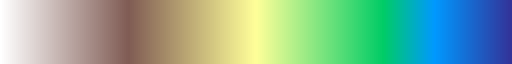

In [3632]:
cmap = plt.get_cmap('terrain').reversed()  # Choose a colormap
#num_runs = len(selected_runs)

colors = [cmap(i / 11) for i in range(2, 12, 1)]
colors_sensor = {
    1: colors[0],
    2: colors[1],
    3: colors[2],
    4: colors[3],
    8: colors[4],
    16: colors[5],
    32: colors[6],
    64: colors[7],
    128: colors[8],
}
#cmap.reversed()
def get_color_by_sensor_count(sen_count: int):
    return colors_sensor[sen_count]

cmap

In [3633]:
# Print Latex code to define colors.

for key in colors_sensor.keys():
    rgb_color = tuple(np.round(x, 2) for x in colors_sensor[key][:3])
    color_name = f"{key}Color"
    
    print(f"\\definecolor{{{color_name}}}{{rgb}}{{{rgb_color[0]}, {rgb_color[1]}, {rgb_color[2]}}}")


\definecolor{1Color}{rgb}{0.64, 0.54, 0.52}
\definecolor{2Color}{rgb}{0.54, 0.41, 0.35}
\definecolor{3Color}{rgb}{0.73, 0.65, 0.45}
\definecolor{4Color}{rgb}{0.91, 0.88, 0.55}
\definecolor{8Color}{rgb}{0.82, 0.96, 0.56}
\definecolor{16Color}{rgb}{0.46, 0.89, 0.49}
\definecolor{32Color}{rgb}{0.08, 0.82, 0.42}
\definecolor{64Color}{rgb}{0.0, 0.66, 0.82}
\definecolor{128Color}{rgb}{0.08, 0.44, 0.84}


Pre-selected run ids.

In [3634]:
env1_id = [6459]
env2_id = [6465]
sensor_study_ids = [
    6466, # 1 
    6467, # 2
    6480, # 3
    6468, # 4
    6469, # 8
    #6470, # 10
    6471, # 16
    6472, # 32
    6473, # 64
    6474, # 128
]

len(sensor_study_ids)

9

Select from what run to get data. Also choose the Type of data.

In [3635]:
# Select the plot type you want.
selected_plot = Plot.ENV2

# Select here the runs to be ploted.
selected_runs: list[int] = env2_id

# Legacy options. No longer in use?
plot_step = 5
plot_all = True
multiple_runs = True


In [3636]:
"""Get y data fro the summary dict using the ID of the training run.
The tag specifies the selected type of data."""
def get_y_data(summary_dict: dict, id: int, tag: Tag):
    try:
        if tag in [Tag.CUMULATIVE_REWARD, Tag.EP_LENGTH, Tag.TARGET_REACHED]:
            return summary_dict[id]["env"][tag.value]
        if tag in [Tag.DOOR_PASSAGE, Tag.DOOR_BAD, Tag.DOOR_GOOD]:
            return summary_dict[id]["door"][tag.value]
        if tag in [Tag.COLLISION_STAY, Tag.COLLISION_INITIAL, Tag.COLLISION_STAY]:
            return summary_dict[id]["collision"][tag.value]
    except ValueError:
        return []


In [3637]:
"""Get x data from the summary dict. Is based on the recorded step."""
def get_x_data(summary_dict: dict, id: int, tag: Tag):
    d = len(get_y_data(summary_dict, id, tag))
    return summary_dict[id]["steps"][:d]

In [3638]:
"""Filter data to smooth plots."""
def filter_data(data):
    try: 
        return savgol_filter(data, 15, 2)
    except ValueError:
        return []

In [3639]:
def cut_arrays_to_same_length(a: np.ndarray, b:np.ndarray):
    if len(a) != len(b):
        if len(a) < len(b):
            d = len(a)
            b = b[:d]
        else:
            d = len(b)
            a = a[:d]
    return a, b

In [3640]:
def get_passage_quality(good, bad):
    x = good
    y = bad
    try: 
        result = x / (x + y)
    except RuntimeWarning:
        result = 0.0
    return result

Loads the summary pickle file. Needs to be created beforehand by runnning `results_summary_pickle.py`. Otherwise it takes ages to get the plot data. Trust me.

In [3641]:
# Load the pickle with all the run data.
summary_file_path = Path("C:/Users/max.muehlefeldt/Documents/GitHub/unity-machine-learning/python/basic_rl_env/summary_dict.pickle").absolute()

with open(summary_file_path, mode="rb") as file:
    summary_dict = pickle.load(file)

In [3642]:
# Global plot settings
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams["font.family"] = 'serif'

In [3643]:
if selected_plot in [
    Plot.SENSOR_STUDY_EP_LENGTH, 
    Plot.SENSOR_STUDY_REWARD,
    Plot.SENSOR_STUDY_INITIAL_COLLISION,
    Plot.SENSOR_STUDY_CONTINUED_COLLISION,
    Plot.SENSOR_STUDY_DOOR_GOOD,
    Plot.SENSOR_STUDY_DOOR_BAD,
    Plot.SENSOR_STUDY_DOOR_QUALITY
    ]:
    selected_tag = Tag.CUMULATIVE_REWARD
    if selected_plot is Plot.SENSOR_STUDY_EP_LENGTH:
        selected_tag = Tag.EP_LENGTH
    elif selected_plot is Plot.SENSOR_STUDY_INITIAL_COLLISION:
        selected_tag = Tag.COLLISION_INITIAL
    elif selected_plot is Plot.SENSOR_STUDY_CONTINUED_COLLISION:
        selected_tag = Tag.COLLISION_STAY
    elif selected_plot is Plot.SENSOR_STUDY_DOOR_GOOD:
        selected_tag = Tag.DOOR_GOOD
    elif selected_plot is Plot.SENSOR_STUDY_DOOR_BAD:
        selected_tag = Tag.DOOR_BAD
    elif selected_plot is Plot.SENSOR_STUDY_DOOR_QUALITY:
        selected_tag = Tag.DOOR_BAD

    fig = plt.figure(figsize=(9, 7))
    fig.patch.set_alpha(0.)
    gs = fig.add_gridspec(ncols=1, nrows=1, figure=fig)
    axs_first = fig.add_subplot(gs[0, 0])

    #cmap = plt.get_cmap('terrain')  # Choose a colormap
    #num_runs = len(selected_runs)
    #colors = [cmap(i / num_runs) for i in range(num_runs)]  # Generate colors from the colormap

    for idx, id in enumerate(selected_runs):
        #sensor_count = content[id]['stats']['sensorCount']
        sensor_count = summary_dict[id]["file_contents"]["unity_config"]["sensorCount"]
        #print(sensor_count)
        #run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors, run {id}"
        run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors"
        #run_label += f", no LSTM" if id == 6108 else ", with LSTM"

        
        #x = content[id]["x_values"][selected_tag]

        x = get_x_data(summary_dict, id, selected_tag)
        #y = savgol_filter( content[id]["y_values"][selected_tag], 15, 2)
        
        if selected_plot is Plot.SENSOR_STUDY_DOOR_QUALITY:
            selected_tag = Tag.DOOR_BAD
            y_bad = -1 * np.array(get_y_data(summary_dict, id, selected_tag))
            selected_tag = Tag.DOOR_GOOD
            y_good = np.array(get_y_data(summary_dict, id, selected_tag))
            y_bad, y_good = cut_arrays_to_same_length(y_bad, y_good)
            #y = []
            #for index in range(len(y_good)):
                #y.append(get_passage_quality(y_good[index], y_bad[index]))
            y = get_passage_quality(y_good, y_bad)
        elif selected_plot is Plot.SENSOR_STUDY_CONTINUED_COLLISION:
            y = filter_data(filter_data(filter_data(y)))
        elif selected_plot is Plot.SENSOR_STUDY_DOOR_BAD:
            y = -1 * filter_data(get_y_data(summary_dict, id, selected_tag))
        else:
            y = filter_data(get_y_data(summary_dict, id, selected_tag))
        #x = content[id]["x_values"][selected_tag]
        #plt.set_cmap("Dark2")


        axs_first.plot(
            x, 
            y,
            color=get_color_by_sensor_count(sensor_count),  # Apply color from colormap
            label=run_label
            )
    
    
    if selected_plot is Plot.SENSOR_STUDY_REWARD:
        axs_first.set_ylim(-2, 1.4)
        axs_first.axhline(1.25, label="Reward limit = 1.25", color="C3", linestyle="dashed")
        #axs_first.axhline(1.25, label="Reward limit = 1.25", color="C3", linestyle="dashed")
        #axs_first.axhline(1.0, label="Reward limit = 1.0", color="C3", linestyle="dashed")
        axs_first.set_ylabel("Reward")
        axs_first.set_title("Cumulative reward")

    elif selected_plot is Plot.SENSOR_STUDY_EP_LENGTH:
        axs_first.set_ylim(0, 200)
        axs_first.set_ylabel("Length")
        axs_first.set_title("Episode length")
    
    elif selected_plot is Plot.SENSOR_STUDY_INITIAL_COLLISION:
        axs_first.set_ylim(0, 200)
        axs_first.set_ylabel("Count")
        axs_first.set_title("Initial Collisions")

    elif selected_plot is Plot.SENSOR_STUDY_CONTINUED_COLLISION:
        axs_first.set_ylim(0, 200)
        axs_first.set_ylabel("Count")
        axs_first.set_title("Continued Collisions")
    
    elif selected_plot is Plot.SENSOR_STUDY_DOOR_GOOD:
        axs_first.set_title("Correct Door Passages")
        axs_first.set_ylim(0, 95)

    elif selected_plot is Plot.SENSOR_STUDY_DOOR_BAD:
        axs_first.set_title("Incorrect Door Passages")
        axs_first.set_ylim(0, 95)
        
    axs_first.set_xlabel("Step")
    
    if selected_plot is Plot.SENSOR_STUDY_REWARD:
        axs_first.legend(ncol=2)
    else:
        axs_first.legend()
    axs_first.grid()
    
    plt.subplots_adjust(hspace=0.4)
    plt.style.use("default")
    
    plt.tight_layout()
    #plt.savefig(f"{selected_run}_all.pdf")
    
    fig.savefig(f"{selected_runs[0]}-{selected_runs[-1]}_{selected_plot}.pdf")


In [3644]:
summary_dict[6480]["file_contents"]["stats"]

{'sameRoom': 62061,
 'agentInRoomID0': 62095,
 'agentInRoomID1': 61705,
 'targetInRoomID0': 61972,
 'targetInRoomID1': 61828,
 'episodeCount': 123800,
 'sensorCount': 3,
 'runId': 6480,
 'targetRoomIndex0': 61972,
 'targetRoomIndex1': 61828}

In [3645]:
if selected_plot is Plot.COLLISION:
    fig = plt.figure(figsize=(9, 7))
    fig.patch.set_alpha(0.)
    gs = fig.add_gridspec(ncols=1, nrows=1, figure=fig)
    axs_first = fig.add_subplot(gs[0, 0])

    for id in selected_runs:
        #sensor_count = content[id]['stats']['sensorCount']
        sensor_count = summary_dict[id]["file_contents"]["unity_config"]["sensorCount"]
        #print(sensor_count)
        #run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors, run {id}"
        run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors"
        #run_label += f", no LSTM" if id == 6108 else ", with LSTM"

        #x = content[id]["x_values"][selected_tag]
        x = get_x_data(summary_dict, id, selected_tag)
        #y = savgol_filter( content[id]["y_values"][selected_tag], 15, 2)
        #y = savgol_filter( get_y_data(summary_dict, id, selected_tag), 15, 2)
        #x = content[id]["x_values"][selected_tag]
        #axs_first.plot(
        #    x, 
        #    y,
        #    #color=tag_colors[selected_tag]
        #    label=run_label
        #    )

        
        y_initial = filter_data(get_y_data(summary_dict, id, Tag.COLLISION_INITIAL))
        y_stay = filter_data(get_y_data(summary_dict, id, Tag.COLLISION_STAY))

        if len(y_initial) != len(y_stay):
            if len(y_initial) < len(y_stay):
                d = len(y_initial)
                y_stay = y_stay[:d]
                x = x[:d]
            else:
                d = len(y_stay)
                y_initial = y_initial[:d]
                x = x[:d]
        
        y = np.vstack([y_initial, y_stay])

        

        axs_first.stackplot(
            x, y,
            labels=["Initial contact", "Continued contact"],
            alpha=0.8
        )

        axs_first.set_ylim(0, 200)
    #if selected_tag is Tag.CUMULATIVE_REWARD:
    #    #axs_first.set_ylim(-2, 1.5)
    #    axs_first.set_ylim(-2, 1.1)
        #axs_first.axhline(1.25, label="Reward limit = 1.25", color="C3", linestyle="dashed")
    #    axs_first.axhline(1.0, label="Reward limit = 1.0", color="C3", linestyle="dashed")
        axs_first.set_ylabel("Count")
        axs_first.set_title("Collisions")

    #elif selected_tag is Tag.EP_LENGTH:
    #    axs_first.set_ylim(0, 200)
    #    axs_first.set_ylabel("Length")
    #    axs_first.set_title("Episode length")
    
    #elif selected_tag is Tag.DOOR_PASSAGE:
    #    axs_first.set_ylim(-1, 1)
    #    axs_first.set_ylabel("Passage Quality")
    #    axs_first.set_title("Door passage")
    
        axs_first.set_xlabel("Step")
        
        axs_first.legend(title=f"Run {id}")
        axs_first.grid()   

        plt.subplots_adjust(hspace=0.4)
        plt.style.use("default")
        plt.tight_layout()
        #plt.savefig(f"{selected_run}_all.pdf")
        fig.savefig(f"{selected_runs[0]}-{selected_runs[-1]}_{selected_plot}.pdf")

       

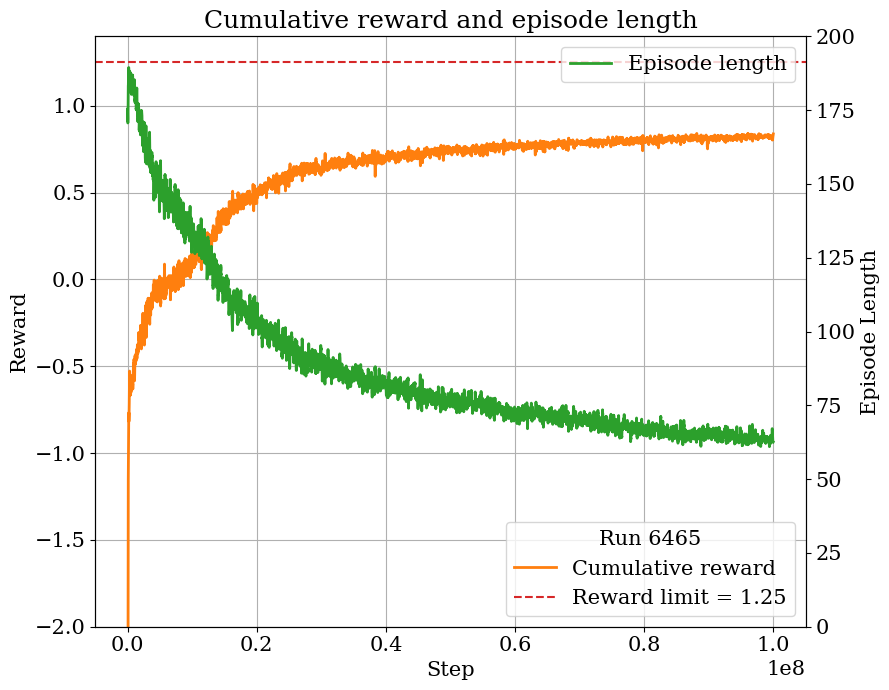

In [3646]:
if selected_plot in [Plot.ENV1, Plot.ENV2]:
    fig = plt.figure(figsize=(9, 7))
    #fig = plt.figure()
    fig.patch.set_alpha(0.)
    
    gs = fig.add_gridspec(ncols=1, nrows=1, figure=fig)

    # First plot.
    #selected_tag = Tag.EP_LENGTH
    axs_first = fig.add_subplot(gs[0, 0])
    #fig.suptitle(f"Runs {selected_runs[0]} - {selected_runs[-1]}", y=0.95)
    #fig.tight_layout()

    for id in selected_runs:
        #sensor_count = content[id]['stats']['sensorCount']
        sensor_count = summary_dict[id]["file_contents"]["unity_config"]["sensorCount"]
        #print(sensor_count)
        #run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors, run {id}"

        run_label = f"Cumulutive reward"
        selected_tag = Tag.CUMULATIVE_REWARD
        #x = content[id]["x_values"][selected_tag]
        x = get_x_data(summary_dict, id, selected_tag)
        #y = savgol_filter( content[id]["y_values"][selected_tag], 15, 2)
        y = filter_data(get_y_data(summary_dict, id, selected_tag))
        #x = content[id]["x_values"][selected_tag]
        axs_first.plot(
            x, 
            y,
            color=tag_colors[selected_tag],
            label="Cumulative reward",
            linewidth=2.0,
            )
        axs_first.set_ylim(
            -2, 
            1.1 if selected_plot is Plot.ENV1 else 1.4
        )
        axs_first.set_ylabel("Reward")
        reward_label = "Reward limit = 1.0" if selected_plot is Plot.ENV1 else  "Reward limit = 1.25"
        axs_first.axhline(
            1.0 if selected_plot is Plot.ENV1 else 1.25,
            label=reward_label, color="C3", linestyle="dashed"
        )

        selected_tag = Tag.EP_LENGTH
        x = get_x_data(summary_dict, id, selected_tag)
        y = filter_data(get_y_data(summary_dict, id, selected_tag))
        axs_second = axs_first.twinx()
        axs_second.plot(
            x, 
            y,
            color=tag_colors[selected_tag],
            label="Episode length",
            linewidth=2.0,
            )
        axs_second.set_ylim(0, 200)
        axs_second.set_ylabel("Episode Length")
        #fig.suptitle("Cumulative reward and episode length")
    
    """if selected_tag is Tag.CUMULATIVE_REWARD:
        #axs_first.set_ylim(-2, 1.5)
        axs_first.set_ylim(-2, 1.1)
        #axs_first.axhline(1.25, label="Reward limit = 1.25", color="C3", linestyle="dashed")
        axs_first.axhline(1.0, label="Reward limit = 1.0", color="C3", linestyle="dashed")
        axs_first.set_ylabel("Reward")
        axs_first.set_title("Cumulative reward")

    elif selected_tag is Tag.EP_LENGTH:
        axs_first.set_ylim(0, 200)
        axs_first.set_ylabel("Length")
    axs_first.set_title("Episode length")"""
    axs_first.set_title("Cumulative reward and episode length")
    axs_first.set_xlabel("Step")
    
    axs_second.legend()
    #axs_second.grid(None)
    axs_first.legend(title=f"Run {id}")
    #axs_second.grid()
    #axs_first.grid()
    #plt.grid()

    axs_first.grid(None)

    plt.subplots_adjust(hspace=0.4)
    plt.style.use("default")
    plt.tight_layout()
    #plt.savefig(f"{selected_run}_all.pdf")
    fig.savefig(f"{selected_runs[0]}-{selected_runs[-1]}_{selected_plot}.pdf")

In [3647]:
if selected_plot is Plot.DOOR:
    fig = plt.figure(figsize=(9, 7))
    #fig = plt.figure()
    fig.patch.set_alpha(0.)
    
    gs = fig.add_gridspec(ncols=1, nrows=1, figure=fig)

    # First plot.
    #selected_tag = Tag.EP_LENGTH
    axs_first = fig.add_subplot(gs[0, 0])
    #fig.suptitle(f"Runs {selected_runs[0]} - {selected_runs[-1]}", y=0.95)
    #fig.tight_layout()

    for id in selected_runs:
              
        selected_tag = Tag.DOOR_BAD
        x = get_x_data(summary_dict, id, selected_tag)
        y = filter_data(get_y_data(summary_dict, id, selected_tag))
        y = -1 * y

        axs_first.plot(
            x, 
            y,
            #color=tag_colors[selected_tag],
            label="Incorrect passage",
            linewidth=2.0,
            )

        selected_tag = Tag.DOOR_GOOD
        x = get_x_data(summary_dict, id, selected_tag)
        y = filter_data(get_y_data(summary_dict, id, selected_tag))
       
        axs_first.plot(
            x, 
            y,
            label="Correct passage",
            linewidth=2.0,
            )
        
    axs_first.set_title("Door passage")
    axs_first.set_xlabel("Step")
    
    
    axs_first.legend(title=f"Run {id}")
    axs_first.grid()

    plt.subplots_adjust(hspace=0.4)
    plt.style.use("default")
    plt.tight_layout()
    #plt.savefig(f"{selected_run}_all.pdf")
    fig.savefig(f"{selected_runs[0]}-{selected_runs[-1]}_{selected_plot}.pdf")

In [3648]:
if selected_plot is Plot.DOOR_HIST:
    fig = plt.figure(figsize=(9, 7))
    #fig = plt.figure()
    fig.patch.set_alpha(0.)
    
    gs = fig.add_gridspec(ncols=1, nrows=1, figure=fig)

    # First plot.
    #selected_tag = Tag.EP_LENGTH
    axs_first = fig.add_subplot(gs[0, 0])
    #fig.suptitle(f"Runs {selected_runs[0]} - {selected_runs[-1]}", y=0.95)
    #fig.tight_layout()

    for id in selected_runs:
              
        selected_tag = Tag.DOOR_BAD
        x = get_x_data(summary_dict, id, selected_tag)
        y_bad = -1 * filter_data(get_y_data(summary_dict, id, selected_tag))
        #y = -1 * y


        #axs_first.hist(
        #    #x, 
        #    y,
        #    #color=tag_colors[selected_tag],
        #    label="Incorrect passage",
        #    linewidth=2.0,
        #    )

        selected_tag = Tag.DOOR_GOOD
        x = get_x_data(summary_dict, id, selected_tag)
        y_good = filter_data(get_y_data(summary_dict, id, selected_tag))

        y_bad, y_good = cut_arrays_to_same_length(y_bad, y_good)

        # Use a constant bin width to make the two histograms easier to compare visually
        #bin_width = 1
        #bins = np.arange(np.min([y_bad, y_good]),
                            #np.max([y_bad, y_good]) + bin_width, bin_width)
        axs_first.hist(
            #x, 
            y_bad,
            weights=-np.ones_like(y_bad),
            #bins=bins,
            label="Inorrect passage",
            )
        axs_first.hist(
            #x, 
            y_good,
            #bins=bins,
            label="Correct passage",
            )
        
    axs_first.set_title("Door passage")
    axs_first.set_xlabel("Step")
    axs_first.axhline(0, color="k")
    
    axs_first.legend()
    axs_first.grid()

    plt.subplots_adjust(hspace=0.4)
    plt.style.use("default")
    plt.tight_layout()
    #plt.savefig(f"{selected_run}_all.pdf")
    fig.savefig(f"{selected_runs[0]}-{selected_runs[-1]}_{selected_plot}.pdf")

In [3649]:
if selected_plot in [
    Plot.STEP_PENALTY_EP_LENGTH
    ]:
    selected_tag = Tag.CUMULATIVE_REWARD

    fig = plt.figure(figsize=(9, 7))
    fig.patch.set_alpha(0.)
    gs = fig.add_gridspec(ncols=1, nrows=1, figure=fig)
    axs_first = fig.add_subplot(gs[0, 0])

    for id in selected_runs:
        step_penalty = summary_dict[id]["file_contents"]["unity_config"]["stepPenalty"]
        run_label = f"{step_penalty}"

        x = get_x_data(summary_dict, id, selected_tag)
        y = filter_data(get_y_data(summary_dict, id, selected_tag))
        
        axs_first.plot(
            x, 
            y,
            label=run_label
            )

    #axs_first.set_ylim(0, 200)
    axs_first.set_ylabel("Length")
    axs_first.set_title("Episode length")
    axs_first.set_xlabel("Step")
    
    axs_first.legend()
    axs_first.grid()   

    plt.subplots_adjust(hspace=0.4)
    plt.style.use("default")
    plt.tight_layout()
    #plt.savefig(f"{selected_run}_all.pdf")
    fig.savefig(f"{selected_runs[0]}-{selected_runs[-1]}_{selected_plot}.pdf")

## Get result data
To highlight the final performance of the NN.

In [3650]:
def get_base_result_string_data(summary_dict: dict, id:int) -> tuple[str, dict]:

    # Initialise the string and data dict.
    s = ""
    data = {}

    # Get y data.
    y_collision_initial = get_y_data(summary_dict, id, Tag.COLLISION_INITIAL)
    y_collision_stay = get_y_data(summary_dict, id, Tag.COLLISION_STAY)
    y_cumulative_reward = get_y_data(summary_dict, id, Tag.CUMULATIVE_REWARD)
    y_ep_length = get_y_data(summary_dict, id, Tag.EP_LENGTH)
    y_target_reached = get_y_data(summary_dict, id, Tag.TARGET_REACHED)

    # Get x data.
    x_steps = get_x_data(summary_dict, id, Tag.EP_LENGTH)

    # Get other data.
    data["sensor_count"] = summary_dict[id]["file_contents"]["unity_config"]["sensorCount"]

    data["num_datapoints"] = 100
    num_datapoints = 100

    s += "\\hline \n"
    s += "Parameter & Value & Performance Indicator & Value \\\\ \n"
    s += "\\hline \n"

    data["final_cumulative_reward"] = np.mean(y_cumulative_reward[-num_datapoints:])
    s+= f"Range sensor count & {data['sensor_count']} & Cumulative reward & {np.round(data['final_cumulative_reward'], 2)} \\\\ \n"

    data["final_cumulative_reward_std"] = np.std(y_cumulative_reward[-num_datapoints:])
    s+= f"Hidden layers & 1 & Cumulative reward STD & {np.round(data['final_cumulative_reward_std'], 2)} \\\\ \n"

    data["final_ep_length"] = np.mean(y_ep_length[-num_datapoints:])
    s += f"Hidden units & 512 & Episode length & {np.round(data['final_ep_length'], 2)} \\\\ \n"
    
    data["target_rate"] = (np.mean(y_target_reached[-num_datapoints:]) * 100) / (10000 / np.mean(y_ep_length[-num_datapoints:]))
    
    #final_collision_rate = 100 - (np.mean(y_initial[-10:]) / 10000) * 100
    steps_without_continued_col = 10000 - np.mean(y_collision_stay[-num_datapoints:])
    data["final_collision_rate"] = (np.mean(y_collision_initial[-num_datapoints:]) / (steps_without_continued_col)) * 100
    #print(100 -  / 10000 * 100)
    s += f"LSTM layer size & 64 & Target rate [\\%] & {np.round(data['target_rate'], 2)} \\\\ \n"

    s += f"& & Collision rate [\\%] & {np.round(data['final_collision_rate'], 2)} \\\\ \n"
    
    data["performed_steps"] = summary_dict[selected_runs[0]]["steps"][-1]
    performed_steps = "{:.0e}".format(data["performed_steps"])
    s += f"& & Total performed steps & {performed_steps} \\\\ \n"
    s += "\\hline"

    return s, data


Get Env 1 data. 6459 is an applicable run.

In [3651]:
if selected_plot is Plot.RESULT_DATA_ENV1:
    for id in selected_runs:
        s, _ = get_base_result_string_data(summary_dict, id)
        print(s)


Get Env 2 data. 6465 is candidate.

In [3652]:
def get_env2_result_string_data(summary_dict: dict, id: int) -> tuple[str, dict]:
    s, data = get_base_result_string_data(summary_dict, id)
    s = "\\hline".join(s.split("\\hline")[:-1])

    # Get y data.
    y_door_passage_incorrect = get_y_data(summary_dict, id, Tag.DOOR_BAD)
    y_door_passage_correct = get_y_data(summary_dict, id, Tag.DOOR_GOOD)
    y_ep_length = get_y_data(summary_dict, id, Tag.EP_LENGTH)

    # Get x data.
    x_steps = get_x_data(summary_dict, id, Tag.EP_LENGTH)

    num_datapoints = data["num_datapoints"]

    data["door_passage_quality"] = get_passage_quality(
            np.mean(y_door_passage_correct[-num_datapoints:]),
            (-1* np.mean(y_door_passage_incorrect[-num_datapoints:]))
        )
    
    data["door_passage_total"] = np.mean(y_door_passage_correct[-num_datapoints:]) + (-1 * np.mean(y_door_passage_incorrect[-num_datapoints:]))
    s += f"& & Door passage quality & {np.round(data['door_passage_quality'], 2)} \\\\ \n"

    data["final_ep_length"] = np.mean(y_ep_length[-num_datapoints:])
    data["final_ep_count"] = 10000 / data["final_ep_length"] 

    data["door_passage_per_ep"] = data["door_passage_total"] / data["final_ep_count"]

    s += f"& & Door passages per episode & {np.round(data['door_passage_per_ep'], 2)} \\\\ \n"
    #s += f"& & Door passages total & {np.round(data['door_passage_total'], 3)} \\\\ \n"
    s += "\\hline"

    return s, data
    

Generate environment 2 result table.

In [3653]:
if selected_plot is Plot.RESULT_DATA_ENV2:
    for id in selected_runs:
        s, _ = get_env2_result_string_data(summary_dict, id)
        print(s)


Generate Latex table containing sensor study results.

In [3654]:
def calculate_position(x, min_val, max_val):
    # Calculate the midpoint
    #midpoint = (min_val + max_val) / 2.0
    
    # Calculate the position
    #position = 2 * (x""" - midpoint""") / (max_val - min_val)
    #position = 2 * (x) / (max_val - min_val)
    position = (x - min_val) / (max_val - min_val)

    if position < 0.0:
        return 0.0
    elif position > 1.0:
        return 1.0
    return position

def get_colour_string(value, data: dict, tag, low_is_good = False) -> str:
    all_values = []
    for id in data.keys():
        all_values.append(data[id][tag])

    max_value = np.max(all_values)
    min_value = np.min(all_values)

    pos = calculate_position(value, min_value, max_value)

    max_alpha_value = 80

    if low_is_good:
        #if pos <= 0:
        #    s = f"{{green!{np.round(pos * -max_alpha_value, 2)}}}"
        #else:
        #    s = f"{{red!{np.round(pos * max_alpha_value, 2)}}}"
        s = f"{{LimeGreen!{np.round((1-pos) * max_alpha_value, 2)}}}"
    else:
        #if pos <= 0:
        #    s = f"{{red!{np.round(pos * -max_alpha_value, 2)}}}"
        #else:
        #    s = f"{{green!{np.round(pos * max_alpha_value, 2)}}}"
        s = f"{{LimeGreen!{np.round((pos) * max_alpha_value, 2)}}}"

    return f"\\cellcolor{s}"

In [3655]:
if selected_plot is Plot.RESULT_DATA_SENSOR_STUDY:
    run_data = {}

    for id in selected_runs:
        
        _, data = get_env2_result_string_data(summary_dict, id)
        run_data[id] = data

    print("\\hline")
    print("& \\multicolumn{9}{c}{Sensor count} \\\\")
    
    s = f"Performance indicator & "
    for id in selected_runs:
        c = run_data[id]['sensor_count']
        s+= f"\\cellcolor{{{c}Color!50}}{c} & "
    s = s[:-2] + "\\\\"
    print(s)
    print("\\hline")

    colour_cell = True
    low_good = True
    high_good = False

    performance_indicators = [
        ("Sensors", "sensor_count"),
        ("Cumulative reward", "final_cumulative_reward", high_good),
        ("Cumulative reward STD", "final_cumulative_reward_std", low_good),
        ("Episode length", "final_ep_length", low_good),
        ("Target rate [\\%]", "target_rate", high_good),
        ("Collision rate [\\%]", "final_collision_rate", low_good),
        ("Door passage quality","door_passage_quality", high_good),
        #("Incorrect Door passages","door_passage_incorrect"),
        #("Correct Door passages","door_passage_correct")
        ("Door passages per episode", 'door_passage_per_ep', high_good),
        #("Door passage count","door_passage_total", high_good)
    ]
    for indicator in performance_indicators:
        if indicator == ("Sensors", "sensor_count"):
            continue
        s = f"{indicator[0]} & "

        for id in run_data.keys():
            value = np.round(run_data[id][indicator[1]], 2)
            #addition = ""
            #if indicator[1] in ["target_rate", "final_collision_rate"]:
            #    addition = "\\%"
            s += f"{get_colour_string(value, run_data, indicator[1], low_is_good=indicator[2])}{value} & "
        s = s[:-2] + "\\\\"
        print(s)
    print("\\hline")